# About the Project

## Background

Dalam industri telekomunikasi yang sangat kompetitif, **mempertahankan pelanggan sama pentingnya dengan mendapatkan pelanggan baru**. Churn pelanggan menjadi tantangan utama karena dapat mengurangi pendapatan dan loyalitas merek. Dengan **mengidentifikasi pelanggan yang berisiko sejak dini**, perusahaan dapat mengambil tindakan yang tepat untuk mencegah mereka berhenti.

## Goal

Mengembangkan model prediktif yang mampu **mengidentifikasi pelanggan yang kemungkinan besar akan melakukan churn**, sehingga perusahaan dapat menjalankan strategi retensi yang lebih proaktif dan personal berbasis data historis pelanggan.

## Objective

Membangun model klasifikasi untuk mendeteksi pelanggan berisiko tinggi churn dan mengidentifikasi faktor-faktor utamanya menggunakan metrik seperti `F1-score`, `Precision`, `Recal`l, dan `ROC AUC`.

# About the Data

- **Customerid**: id dari customer
- **Gender**: gender dari customer
- **Seniorcitizen**: apakah merupakan senior citizen atau tidak
- **Partne**r: apakah memiliki partner atau tidak
- **Dependents**: apakah memiliki tanggungan atau tidak seperti anak dll
- **Tenure**: tenure dari langganan customer
- **PhoneService**: apakah menggunakan layanan phone atau tidak
- **MultipleLines**: apakah menggunakan multiple lines atau tidak
- **InternetService**: Tipe dari internet service yang digunakan
- **OnlineSecurity**: apakah menggunakan fitur online security
- **OnlineBackup**: apakah menggunakan fitur online backup
- **DeviceProtection**: apakah menggunakan fitur device protection
- **TechSupport**: apakah menggunakan fitur tech support atau tidak
- **StreamingTV**: apakah menggunakan fitur streaming TV atau tidak
- **StreamingMovies**: apakah menggunakan fiture streaming film atau tidak
- **Contract**: tipe contract dari customer
- **PaperlessBilling**: apakah menggunakan fitur paperless billing atau tidak
- **PaymentMethod**: payment tipe yang digunakan oleh customer
- **MonthlyCharges**: total charges/biaya bulanan yang dibayarkan
- **TotalCharges**: total charges secara keseluruhan yang dibayarkan
- **Churn**: target variabel yang menunjukan bahwa customer churn atau tidak

# Dataset & Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import joblib
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [5]:
df = pd.read_csv("Telecom_Customers_Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Custom Functions

In [7]:
# ==== Preprocessing & Feature Engineering ====
def preprocess_churn_data(df):
    # Drop customerID
    df.drop('customerID', axis=1, inplace=True)

    # Convert TotalCharges to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Drop rows with NaN
    df.dropna(inplace=True)

    # Convert 'Churn' to binary
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

    # Numerical Features
    num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

    # Categorical features
    cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                    'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

    multi_cat_features = [col for col in cat_features if len(df[col].unique()) > 2]
    bin_cat_features = [col for col in cat_features if len(df[col].unique()) == 2]

    # Ubah kolom binary jadi numerik
    for col in bin_cat_features:
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) == 2:
            # Mapping otomatis: nilai pertama ke 0, kedua ke 1
            mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
            df[col] = df[col].map(mapping)

    return df, num_features, multi_cat_features, bin_cat_features

def feature_engineering(df):
    # Create new feature: average monthly payment
    df['AvgMonthly'] = df['TotalCharges'] / (df['tenure'] + 1)

    # Create binary feature: is_long_term_customer
    df['is_long_term_customer'] = df['tenure'].apply(lambda x: 1 if x > 12 else 0)

    # Grouping tenure
    df['TenureGroup'] = pd.cut(
        df['tenure'],
        bins=[0, 12, 24, 48, 60, 72],
        labels=['0-12', '13-24', '25-48', '49-60', '61-72']
    )

    # Create binary feature: high_charges
    df['HighMonthly'] = df['MonthlyCharges'].apply(lambda x: 1 if x > df['MonthlyCharges'].median() else 0)

    return df

# ==== Get Models ====
def get_classifiers():
    models = [
        LogisticRegression(class_weight='balanced', max_iter=1000),
        KNeighborsClassifier(n_jobs=-1),
        DecisionTreeClassifier(class_weight='balanced', random_state=42),
        RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
        GradientBoostingClassifier(random_state=42),
        XGBClassifier(scale_pos_weight=(y == 0).sum() / (y == 1).sum(), use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
        SVC(probability=True, class_weight='balanced', random_state=42)
    ]
    names = ['LogReg', 'KNN', 'DecisionTree', 'RandomForest', 'GradientBoost', 'XGBoost', 'SVM']
    return models, names

# ==== Evaluation Function ====
def evaluate_classifier(X, y, pipeline):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    recall = cross_val_score(pipeline, X, y, scoring='recall', cv=skf, n_jobs=-1)
    precision = cross_val_score(pipeline, X, y, scoring='precision', cv=skf, n_jobs=-1)
    f1 = cross_val_score(pipeline, X, y, scoring='f1', cv=skf, n_jobs=-1)
    roc_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=skf, n_jobs=-1)

    return {
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# === Evaluate Model with SMOTE ===
def evaluate_classifier_with_sampling(X, y, pipeline):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    recall_scores, roc_auc_scores = [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]

        recall_scores.append(recall_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_proba))

    return recall_scores, roc_auc_scores

def plot_feature_importance(pipeline, model_name, X, y, top_n=15):
    # Fit pipeline
    pipeline.fit(X, y)

    # Ambil model setelah preprocessing dan SMOTE
    clf = pipeline.named_steps['classifier']

    # Ambil nama fitur dari preprocessor
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    # Ambil nilai feature importance
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        importances = np.abs(clf.coef_).flatten()
    else:
        print(f"Model {model_name} tidak mendukung feature importance secara langsung.")
        return

    # Buat DataFrame untuk visualisasi
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(top_n)

    # Visualisasi
    plt.figure(figsize=(10, 6))
    plt.barh(fi_df['feature'], fi_df['importance'])
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return fi_df

# === IQR Method ===
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# === Data Sampling ===
def get_sampling_pipelines_with_preprocessing(num_features, cat_features):
    # ColumnTransformer preprocessing
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ])

    # Sampling methods to compare
    sampling_methods = {
        'No Sampling': None,
        'RandomOverSampler': RandomOverSampler(random_state=42),
        'RandomUnderSampler': RandomUnderSampler(random_state=42),
        'SMOTE': SMOTE(random_state=42),
        'SMOTEENN': SMOTEENN(random_state=42),
        'SMOTETomek': SMOTETomek(random_state=42),
    }

    pipelines, names = [], []

    for name, sampler in sampling_methods.items():
        if sampler:
            pipeline = ImbPipeline([
                ('preprocessor', preprocessor),
                ('sampler', sampler),
                ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
            ])
        else:
            pipeline = ImbPipeline([
                ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
            ])
        pipelines.append(pipeline)
        names.append(name)

    return pipelines, names

# EDA

## Cleaning

In [8]:
# Konversi TotalCharges ke numerik
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [9]:
# Cek nilai null setelah konversi
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


Terdapat 11 missing values pada kolom `TotalCharges`. Hal ini kemungkinan disebabkan oleh pelanggan yang baru saja bergabung sehingga belum memiliki total tagihan. Missing values tersebut dapat diatasi dengan menghapus baris-baris yang bersangkutan dari dataset karena jumlahnya relatif kecil dan tidak signifikan secara statistik.

In [10]:
# Drop nilai null
df = df.dropna(subset=['TotalCharges'])
df = df.reset_index(drop=True)

In [11]:
# Cek duplikat
df.duplicated().sum()

np.int64(0)

Tidak ada nilai duplikasi di dataset sehingga kita bisa lanjut ke tahap berikutnya.

## Explore Numerical Features

In [12]:
# Numerical features
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

df[num_features].describe().round(3)

,tenure,MonthlyCharges,TotalCharges
count,7032.000,7032.000,7032.000
mean,32.422,64.798,2283.300
std,24.545,30.086,2266.771
min,1.000,18.250,18.800
25%,9.000,35.588,401.450
50%,29.000,70.350,1397.475
75%,55.000,89.862,3794.738
max,72.000,118.750,8684.800


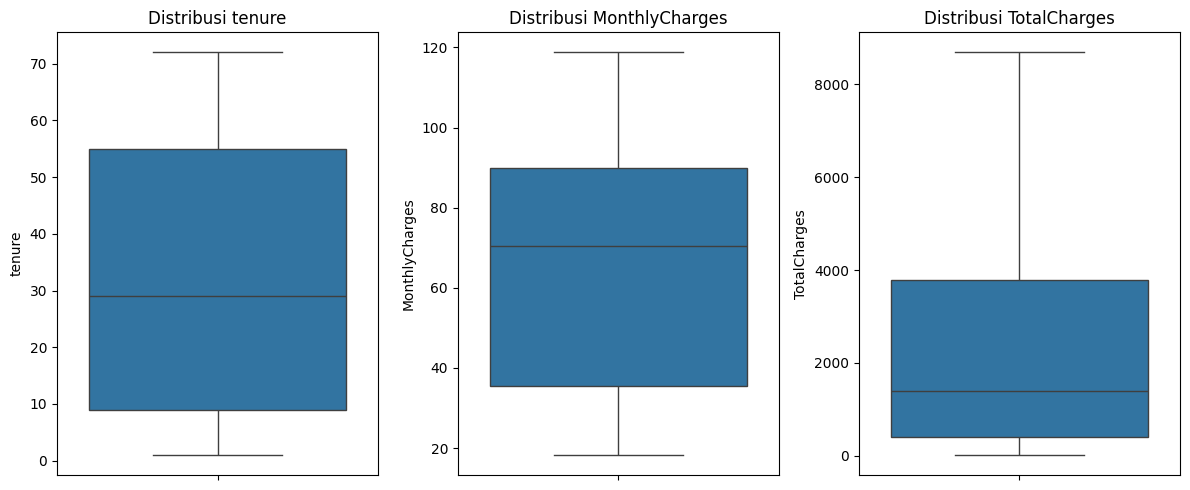

In [13]:
plt.figure(figsize=(12, 5))

for i, feature in enumerate(num_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Distribusi {feature}')

plt.tight_layout()
plt.show()

In [14]:
# Deteksi outliers dengan IQR
for col in num_features:
    outliers_totalcharges = detect_outliers_iqr(df, col)
    print(f"Jumlah outlier pada {col}: {len(outliers_totalcharges)}")

Jumlah outlier pada tenure: 0
Jumlah outlier pada MonthlyCharges: 0
Jumlah outlier pada TotalCharges: 0


Berdasarkan hasil deteksi outlier menggunakan metode Interquartile Range (IQR), tidak ditemukan nilai outlier pada kolom-kolom numerik dalam dataset ini. Dengan kata lain, semua nilai berada dalam rentang normal antara Q1 - 1.5 × IQR dan Q3 + 1.5 × IQR untuk masing-masing fitur numerik.

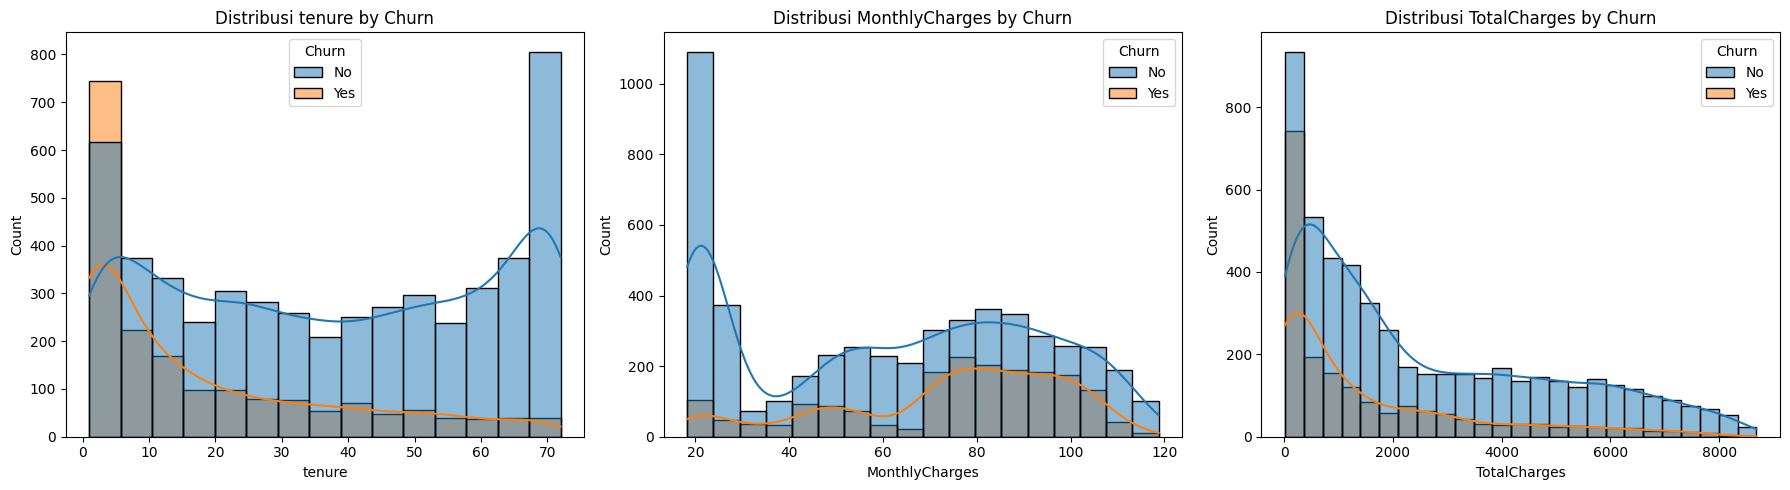

In [15]:
plt.figure(figsize=(18, 5))

for i, feature in enumerate(num_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df, x=feature, hue='Churn', kde=True)
    plt.title(f'Distribusi {feature} by Churn')

plt.tight_layout()
plt.show()

Berdasarkan hasil visualisasi histogram, kolom `tenure` dan `MonthlyCharges` memiliki distribusi yang mendekati normal, meskipun tidak sepenuhnya simetris. Sementara itu, kolom `TotalCharges` menunjukkan distribusi yang right-skewed, dengan mayoritas pelanggan memiliki total tagihan di rentang **0** hingga **2000**.

In [16]:
df[num_features].skew()

,0
tenure,0.237731
MonthlyCharges,-0.222103
TotalCharges,0.961642


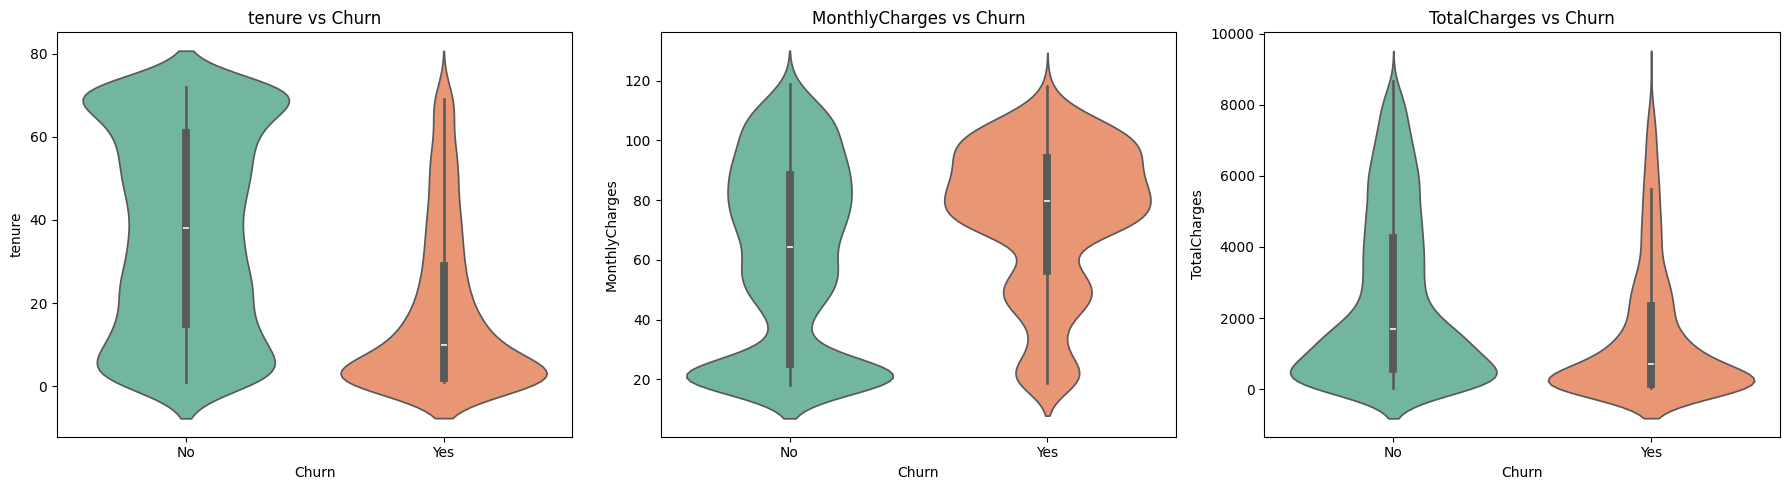

In [17]:
plt.figure(figsize=(18, 5))

for i, feature in enumerate(num_features, 1):
    plt.subplot(1, 3, i)
    sns.violinplot(data=df, x='Churn', y=feature, palette='Set2')
    plt.title(f'{feature} vs Churn')

plt.tight_layout()
plt.show()

- Dari visualisasi violin plot, terlihat bahwa pelanggan yang Churn cenderung memiliki `tenure` yang rendah, dengan median sekitar **10 bulan**. Sebaliknya, pelanggan yang tidak Churn memiliki persebaran tenure yang lebih merata, dengan median sekitar **40 bulan**. Hal ini menunjukkan bahwa pelanggan yang lebih baru lebih rentan untuk berhenti berlangganan.
- Pelanggan yang Churn memiliki tagihan bulanan yang lebih tinggi dibandingkan dengan pelanggan yang tetap berlangganan. Median `MonthlyCharges` pelanggan churn berada di sekitar **80**, dengan sebagian besar berada di rentang **60 hingga 110**. Sementara itu, pelanggan yang tidak churn memiliki median sekitar **65**, dan mayoritas berada di kisaran **20 hingga 80**. Ini menunjukkan bahwa tagihan bulanan yang tinggi bisa menjadi faktor risiko churn.
- Untuk kolom `TotalCharges`, baik pelanggan yang churn maupun yang tidak churn memiliki **median di bawah 2000**, dan tidak terdapat perbedaan distribusi yang mencolok antar kedua kelompok. Hal ini diduga karena `TotalCharges` sangat berkorelasi dengan `tenure`, sehingga pelanggan baru otomatis memiliki nilai `TotalCharges` rendah, terlepas dari apakah mereka churn atau tidak.

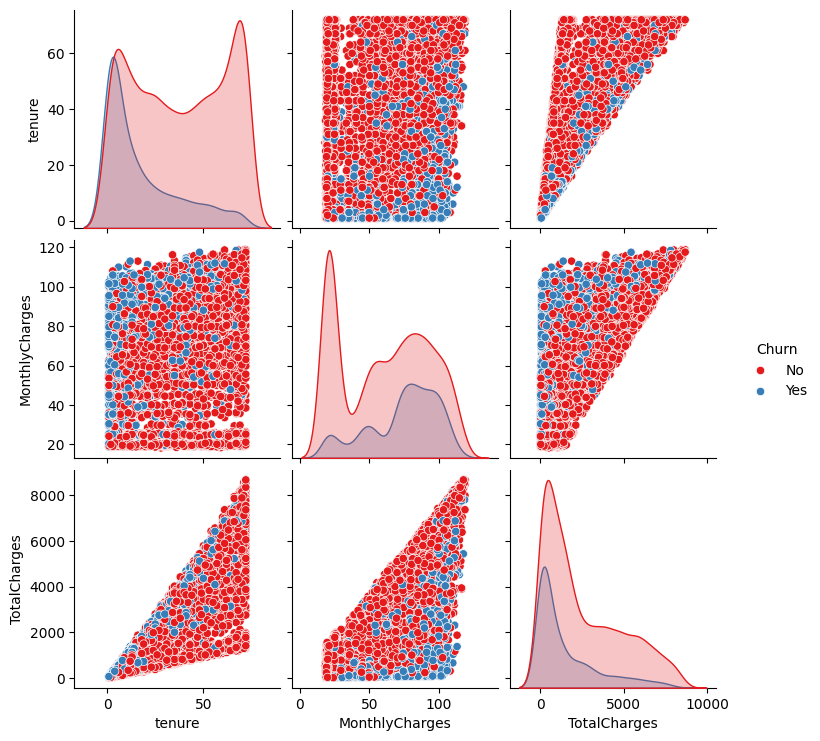

In [18]:
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], hue='Churn', palette='Set1')
plt.show()

In [19]:
df[num_features].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.246862,0.825880
MonthlyCharges,0.246862,1.000000,0.651065
TotalCharges,0.825880,0.651065,1.000000


Berdasarkan scatter plot dan matriks korelasi antar fitur numerik (`tenure`, `MonthlyCharges`, dan `TotalCharges`), dapat disimpulkan beberapa hal penting:

- **Overlap Antar Kelas pada Scatter Plot:** Visualisasi scatter plot menunjukkan bahwa data pelanggan yang Churn dan tidak Churn masih banyak saling tumpang tindih (overlap) pada kombinasi antar fitur numerik. Hal ini mengindikasikan bahwa fitur-fitur numerik tersebut tidak sepenuhnya linearly separable untuk memisahkan kelas Churn.

- **Korelasi Tinggi antara tenure dan TotalCharges:** Dari matriks korelasi, terlihat bahwa kolom tenure dan `TotalCharges` memiliki korelasi positif yang sangat tinggi sebesar **0.83**. Hal ini wajar karena pelanggan yang telah berlangganan lebih lama tentu cenderung memiliki total tagihan yang lebih besar.

- **Korelasi Sedang antara MonthlyCharges dan TotalCharges:** Terdapat korelasi sedang antara `MonthlyCharges` dan `TotalCharges` sebesar **0.65**, yang masuk akal karena tagihan bulanan berkontribusi langsung terhadap total tagihan pelanggan, meskipun masih tergantung pada lama langganan.

- **Korelasi Lemah antara tenure dan MonthlyCharges:** Nilai korelasi sebesar **0.25** antara `tenure` dan `MonthlyCharges` menunjukkan hubungan yang lemah, artinya besar tagihan bulanan tidak terlalu dipengaruhi oleh lamanya pelanggan berlangganan.

- **Implikasi untuk Modeling:** Mengingat adanya korelasi yang tinggi antara beberapa fitur, terutama `tenure` dan `TotalCharges`, maka penting untuk mempertimbangkan potensi **multicollinearity** dalam pemodelan. Dalam kasus seperti ini, disarankan untuk memilih satu dari dua fitur yang sangat berkorelasi (misalnya hanya memilih `tenure` atau `TotalCharges`) agar model lebih stabil dan tidak mengalami redundansi informasi.

## Explore Categorical Features

In [20]:
# Categorical features
cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies',
                'Contract', 'PaperlessBilling', 'PaymentMethod']

multi_cat_features = [col for col in cat_features if len(df[col].unique()) > 2]
bin_cat_features = [col for col in cat_features if len(df[col].unique()) == 2]

print(f"Multi Categorical Features: {multi_cat_features}")
print(f"Binary Categorical Features: {bin_cat_features}")

Multi Categorical Features: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
Binary Categorical Features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']


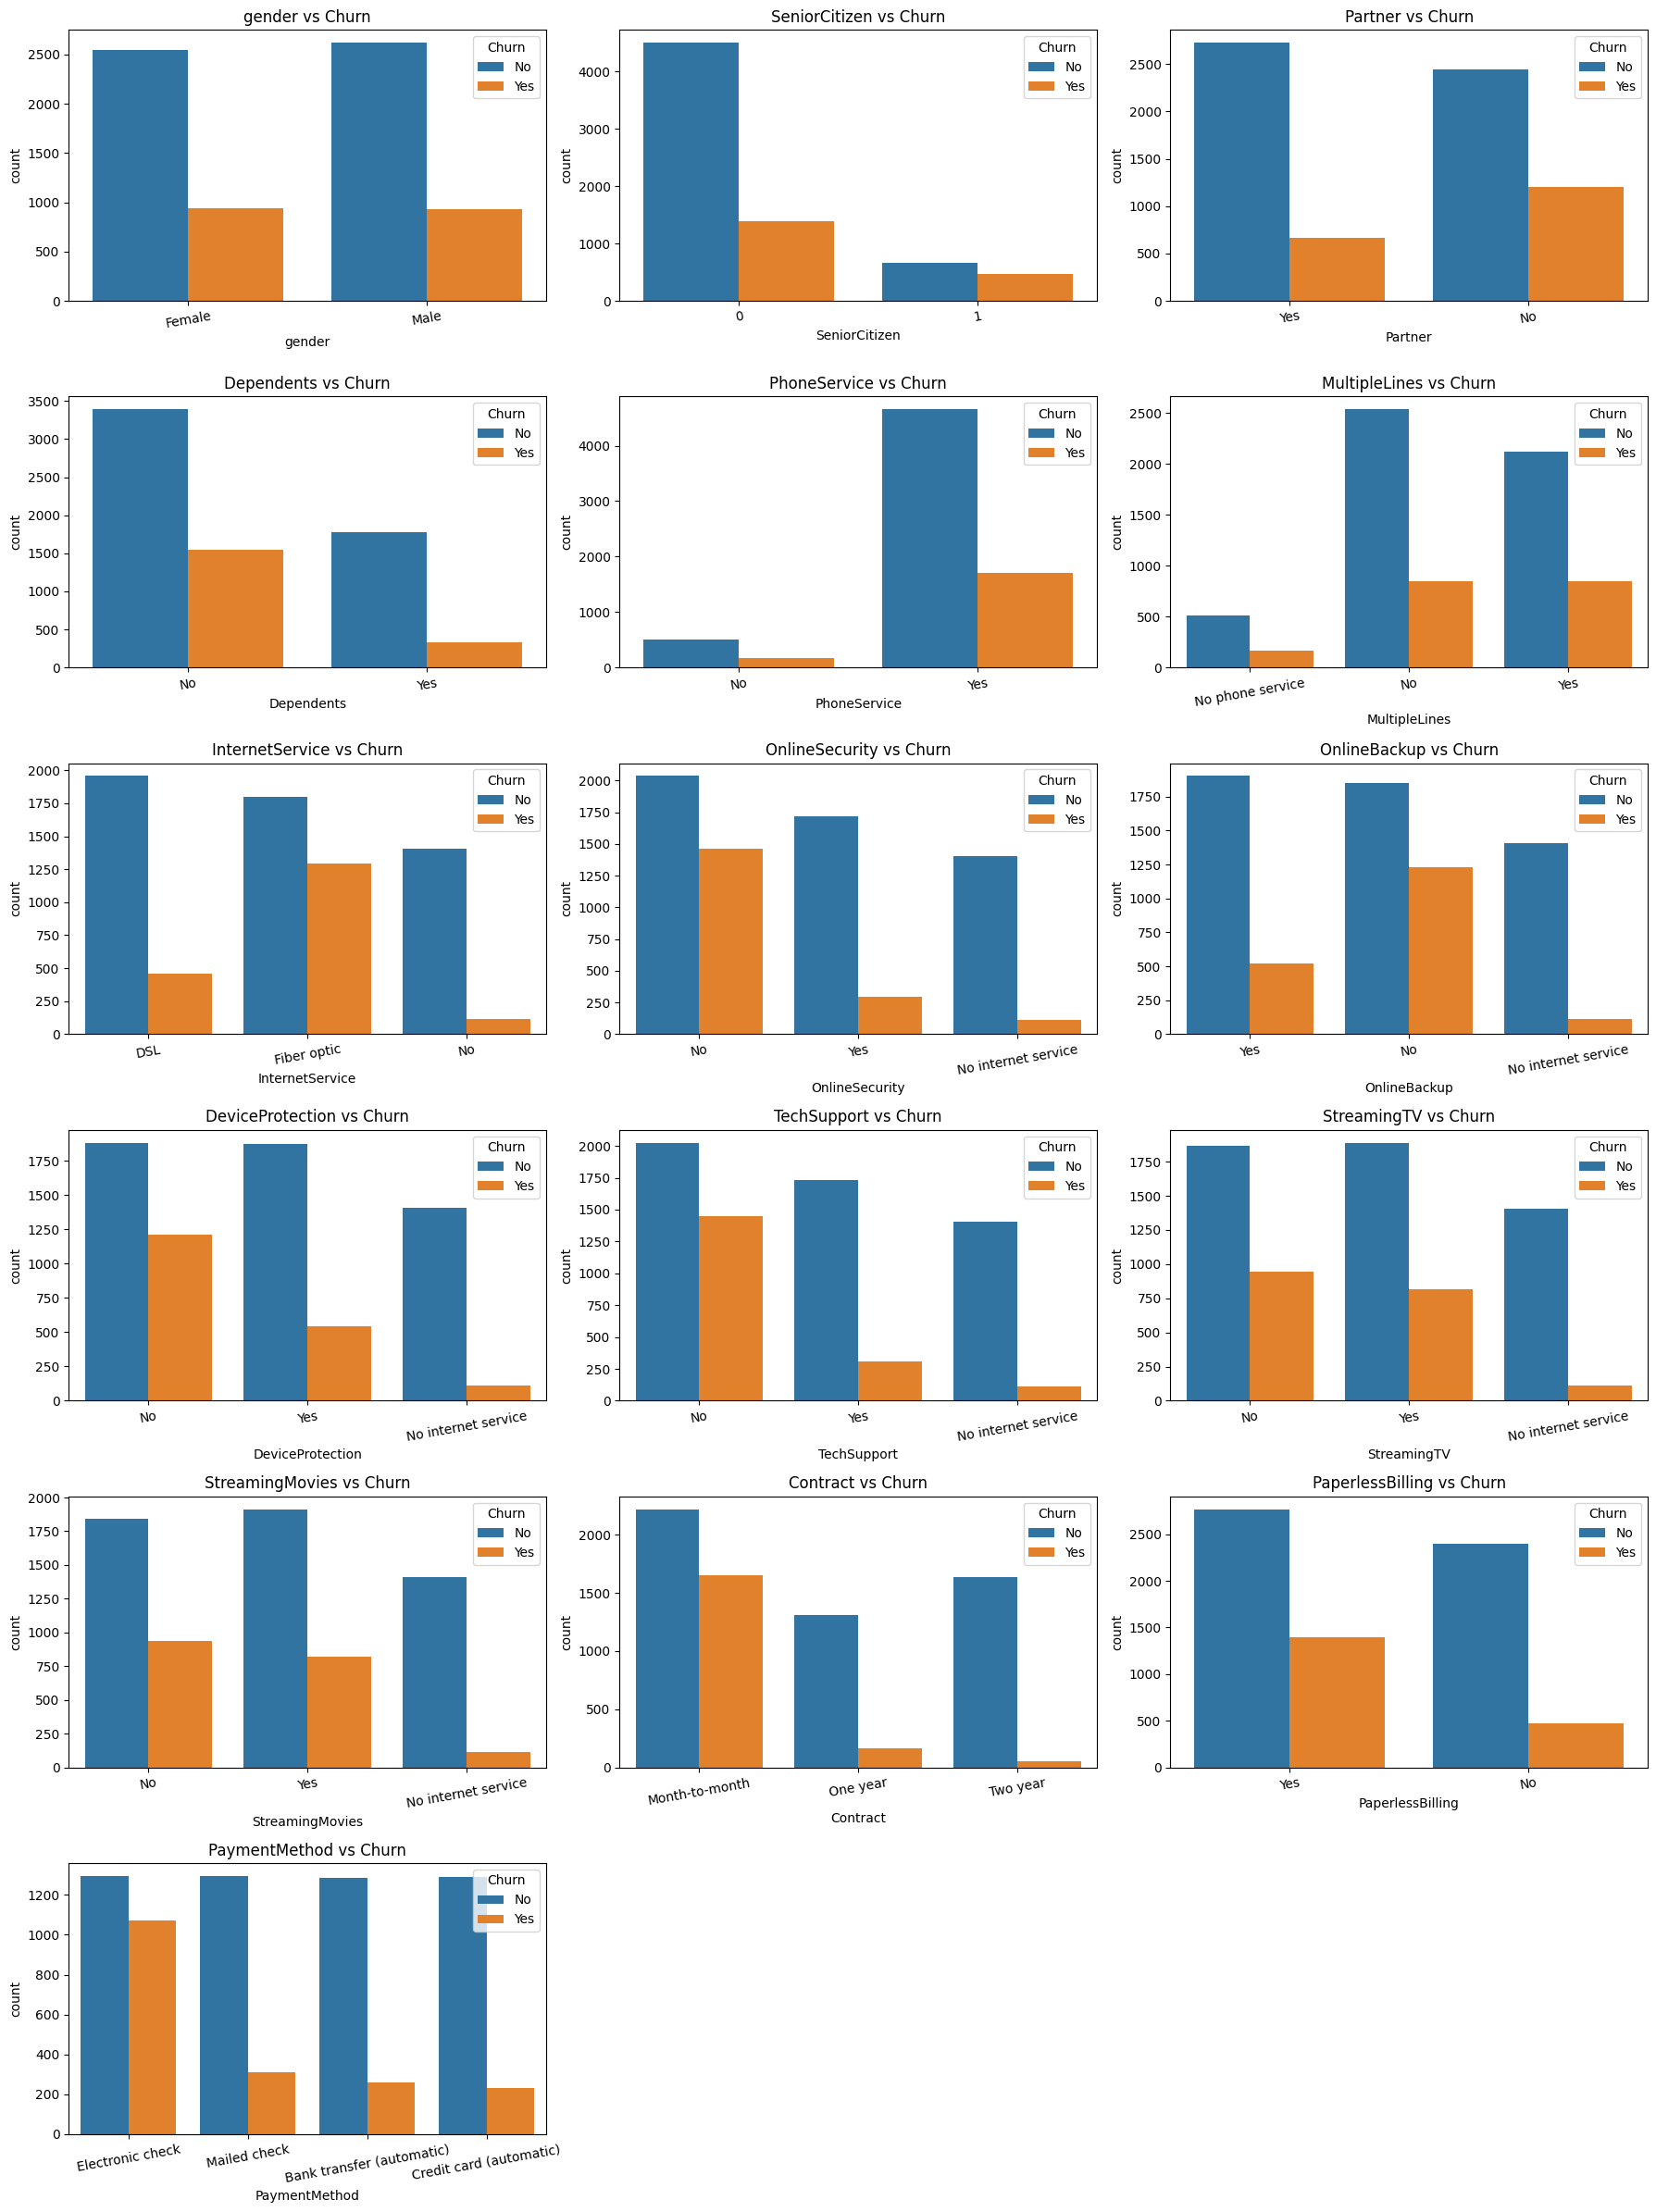

In [21]:
target = 'Churn'
n = len(cat_features)
cols = 3  # jumlah kolom subplot
rows = math.ceil(n / cols)  # hitung jumlah baris yang dibutuhkan

plt.figure(figsize=(6 * cols, 4 * rows))

for i, feature in enumerate(cat_features, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(data=df, x=feature, hue=target)
    plt.title(f'{feature} vs {target}')
    plt.xticks(rotation=10)

plt.tight_layout()
plt.show()

Dari hasil plotting fitur-fitur kategori, terlihat bahwa proporsi pelanggan yang churn dan tidak churn bervariasi pada masing-masing kategori. Namun, sebagian besar kategori didominasi oleh pelanggan yang tidak churn, yang sejalan dengan distribusi target di dataset ini, yaitu **tidak seimbang (imbalance)** dengan proporsi pelanggan **churn sebesar 27%** dan **tidak churn sebesar 73%**.

# Feature Engineering

In [22]:
# Create binary feature: is_long_term_customer
df['is_long_term_customer'] = df['tenure'].apply(lambda x: 1 if x > 12 else 0)
bin_cat_features += ['is_long_term_customer']

# Fitur baru: Rata-rata biaya per bulan
df['AvgMonthly'] = df['TotalCharges'] / (df['tenure'] + 1)

# Grouping tenure
df['TenureGroup'] = pd.cut(
    df['tenure'],
    bins=[0, 12, 24, 48, 60, 72],
    labels=['0-12', '13-24', '25-48', '49-60', '61-72']
)
multi_cat_features += ['TenureGroup']

# High Monthly Charges
df['HighMonthly'] = df['MonthlyCharges'].apply(lambda x: 1 if x > df['MonthlyCharges'].median() else 0)

In [23]:
df.shape

(7032, 25)

In [24]:
df[['AvgMonthly', 'TenureGroup', 'HighMonthly', 'is_long_term_customer']].sample(10)

,AvgMonthly,TenureGroup,HighMonthly,is_long_term_customer
4116,69.352857,25-48,1,1
5675,105.177966,49-60,1,1
5137,25.590299,61-72,0,1
301,79.220000,0-12,1,0
3942,52.247368,13-24,0,1
4679,83.256522,13-24,1,1
12,96.289831,49-60,1,1
6011,56.948571,25-48,0,1
2115,21.612500,49-60,0,1
245,54.680000,0-12,1,0


**Penjelasan Feature Engineering:**
- `is_long_term_customer`: Mengklasifikasikan pelanggan apakah mereka pelanggan jangka panjang atau tidak. Fitur ini dapat digunakan untuk membantu model mengenali bahwa pelanggan yang sudah lama biasanya memiliki risiko churn lebih rendah, karena mereka sudah loyal terhadap layanan.
- `AvgMonthly` **(Rata-rata biaya per bulan)**: Mengukur rata-rata pengeluaran bulanan pelanggan secara keseluruhan. Berbeda dengan `MonthlyCharges` yang mencerminkan biaya bulan terakhir, `AvgMonthly` memperhitungkan total biaya sejauh ini, sehingga bisa memberi insight apakah pelanggan konsisten dalam pengeluarannya atau tidak.
- `TenureGroup`: Mengelompokkan durasi berlangganan ke dalam beberapa rentang waktu (kategori). Pengelompokan ini bisa membuat model lebih stabil dalam mempelajari pola dari pelanggan dengan durasi yang mirip, tanpa harus memproses nilai `tenure` secara numerik terus-menerus. Cocok untuk model yang lebih sensitif terhadap kategori, seperti decision tree atau random forest.
- `HighMonthly`: Menandai apakah pelanggan membayar lebih dari **biaya bulanan median**. Fitur ini bisa membantu memisahkan pelanggan dengan **beban biaya tinggi**, yang berpotensi lebih rentan terhadap churn jika mereka merasa tidak puas dengan layanan. Bisa juga mengindikasikan pelanggan dengan layanan lebih premium.

# Preprocessing

In [25]:
# Ubah target 'Churn' jadi numerik
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Ubah kolom binary jadi numerik
for col in bin_cat_features:
    unique_vals = df[col].dropna().unique()
    if len(unique_vals) == 2:
        # Mapping otomatis: nilai pertama ke 0, kedua ke 1
        mapping = {val: idx for idx, val in enumerate(sorted(unique_vals))}
        df[col] = df[col].map(mapping)

In [26]:
# Buang ID
df = df.drop(columns='customerID')

# Scaling
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthly']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthly']])

# One-hot encoding multi-categorical features
df = pd.get_dummies(df, columns=multi_cat_features, drop_first=True)

In [27]:
df.shape

(7032, 38)

In [28]:
df.sample(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,is_long_term_customer,AvgMonthly,HighMonthly,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureGroup_13-24,TenureGroup_25-48,TenureGroup_49-60,TenureGroup_61-72
3825,0,0,1,0,0.756950,1,1,0.460440,0.735702,0,1,0.553706,1,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,True,True,False,True,False,False,False,False,True,False
2167,0,0,0,0,-1.280248,1,0,-0.693004,-0.987973,0,0,-1.216169,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
5140,1,0,1,0,1.327365,1,1,1.148517,1.793096,0,1,1.215640,1,False,True,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2483,1,0,0,0,-0.057929,1,1,-0.317387,-0.250440,1,1,-0.179240,0,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False
2873,1,0,1,0,-0.424625,1,1,0.737997,-0.190880,0,1,0.700701,1,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False
6491,0,0,0,0,-0.465369,0,0,-0.987182,-0.667473,0,1,-0.788695,0,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False
4383,0,0,0,0,-0.954296,1,1,-0.176115,-0.773512,0,0,-0.199201,0,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
2690,1,0,1,0,0.797694,1,1,0.551851,0.913765,0,1,0.756298,1,False,True,False,False,False,True,False,True,False,True,False,True,False,False,False,True,True,False,True,False,False,False,False,True,False
3321,1,1,0,0,0.227279,1,1,0.177896,0.094436,1,1,0.162281,0,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,False,True,False,True,False,False,False,True,False,False
3968,0,1,0,0,-0.506113,1,1,0.698109,-0.245212,1,1,0.759656,1,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False


Proses preprocessing yang saya terapkan untuk proses modeling di dataset ini adalah:
- **Mengubah Target Variabel (Churn) Menjadi Numerik:** Nilai `'Yes'` diubah menjadi `1`, dan `'No'` menjadi `0` agar dapat digunakan sebagai target dalam model klasifikasi.
- **Encoding Kolom Kategori Biner:** Setiap fitur kategori dengan dua nilai unik (binary categorical features) diubah menjadi bentuk numerik (0 dan 1) menggunakan mapping otomatis berdasarkan urutan nilai.
- **Standarisasi Fitur Numerik:** Kolom numerik seperti `tenure`, `MonthlyCharges`, `TotalCharges`, dan `AvgMonthly` distandarisasi menggunakan **StandardScaler** agar memiliki distribusi dengan **mean = 0** dan **standar deviasi = 1**. Tujuannya adalah untuk menyetarakan skala, terutama penting untuk algoritma yang sensitif terhadap skala (seperti KNN, Logistic Regression, SVM).
- **One-Hot Encoding untuk Fitur Multi-Kategori:** Kolom kategori dengan lebih dari dua nilai unik (multi-categorical features seperti `TenureGroup`, `InternetService`, dll.) diubah menjadi vektor dummy menggunakan `pd.get_dummies()`, dengan opsi `drop_first=True` untuk menghindari multikolinearitas.
- **Menghapus Kolom yang Tidak Relevan:** Kolom `customerID` dihapus karena tidak memberikan kontribusi informasi untuk prediksi dan hanya berfungsi sebagai identifikasi unik pelanggan.

# Traning & Testing

## Check Correlation

In [29]:
# Korelasi numerik dengan target setelah feature engineering
correlations = df.corr(numeric_only=True)['Churn'].sort_values(ascending=False)
print("Korelasi terhadap Churn:")
print(correlations)

Korelasi terhadap Churn:
Churn                                    1.000000
InternetService_Fiber optic              0.307463
PaymentMethod_Electronic check           0.301455
HighMonthly                              0.195273
MonthlyCharges                           0.192858
PaperlessBilling                         0.191454
SeniorCitizen                            0.150541
AvgMonthly                               0.070992
StreamingTV_Yes                          0.063254
StreamingMovies_Yes                      0.060860
MultipleLines_Yes                        0.040033
TenureGroup_13-24                        0.019929
PhoneService                             0.011691
gender                                  -0.008545
MultipleLines_No phone service          -0.011691
DeviceProtection_Yes                    -0.066193
TenureGroup_25-48                       -0.075859
OnlineBackup_Yes                        -0.082307
PaymentMethod_Mailed check              -0.090773
TenureGroup_49-60        

Kita dapat melihat bahwa korelasi antara fitur-fitur dalam dataset terhadap variabel `Churn` setelah melalui proses **feature engineering** dan **preprocessing** sangat bervariasi.

Beberapa fitur yang menunjukkan **korelasi positif** yang cukup kuat dengan `Churn` adalah `InternetService_Fiber optic`, `PaymentMethod_Electronic check`, dan `HighMonthly`, yang mengindikasikan bahwa pelanggan dengan karakteristik ini lebih cenderung melakukan churn.

Sebaliknya, fitur-fitur seperti `tenure`, `is_long_term_customer`, dan `Contract_Two year` memiliki **korelasi negatif yang cukup kuat**, yang berarti pelanggan dengan masa berlangganan lebih lama atau kontrak jangka panjang cenderung lebih loyal.

Informasi ini sangat berguna untuk mengidentifikasi faktor risiko churn, serta dapat dijadikan acuan dalam proses **feature selection** atau **interpretasi model** di tahap modeling selanjutnya.

## Data Sampling

In [30]:
# Hitung distribusi
churn_dist = df['Churn'].value_counts(normalize=True) * 100

# Tampilkan persentase
print("Persentase kelas Churn:")
print(churn_dist)

Persentase kelas Churn:
Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


Karena distribusi kelas pada target bersifat **imbalance**, maka sebelum melanjutkan ke proses modeling, saya melakukan teknik data sampling untuk mengatasi ketidakseimbangan tersebut.

In [31]:
# Import Dataset
df = pd.read_csv("Telecom_Customers_Churn.csv")

# Apply preprocessing
df, num_features, multi_cat_features, bin_cat_features = preprocess_churn_data(df)
df = feature_engineering(df)

# ==== Features & Target ====
X = df.drop('Churn', axis=1)
y = df['Churn']

pipelines, names = get_sampling_pipelines_with_preprocessing(num_features, multi_cat_features)

results = {}

for name, pipeline in zip(names, pipelines):
    recall_scores, roc_auc_scores = evaluate_classifier_with_sampling(X, y, pipeline)
    results[name] = {
        'Recall (mean)': round(np.mean(recall_scores), 4),
        'ROC-AUC (mean)': round(np.mean(roc_auc_scores), 4)
    }

# Tampilkan hasil evaluasi
pd.DataFrame(results).T.sort_values(by='Recall (mean)', ascending=False)

,Recall (mean),ROC-AUC (mean)
SMOTEENN,0.8277,0.8403
No Sampling,0.8010,0.8436
RandomUnderSampler,0.7983,0.8431
RandomOverSampler,0.7978,0.8432
SMOTETomek,0.7967,0.8434
SMOTE,0.7924,0.8435


Berdasarkan hasil eksperimen dengan beberapa metode sampling, didapatkan bahwa **SMOTEENN** menghasilkan nilai rata-rata **recall (0.8267)** dan **ROC-AUC (0.8403)** tertinggi dibandingkan metode lainnya. Oleh karena itu, **SMOTEENN** dipilih sebagai metode sampling yang akan digunakan dalam pipeline modeling selanjutnya.

## Baseline Model

Sebelum melanjutkan ke proses modeling, saya akan terlebih dahulu melakukan evaluasi dengan model baseline untuk menentukan skor recall yang dapat digunakan sebagai threshold, agar dapat menilai apakah model yang kita bangun memiliki kemampuan yang memadai dalam memprediksi apakah seorang pelanggan akan churn atau tidak. Pada tahap ini, saya menggunakan `DummyClassifier` dengan strategi `stratified`, mengingat dataset yang kita miliki memiliki distribusi kelas yang tidak seimbang. Penggunaan strategi `stratified` bertujuan untuk memberikan hasil baseline yang lebih realistis, dengan mempertahankan proporsi distribusi kelas yang ada pada data.

In [32]:
# Import Dataset
df = pd.read_csv("Telecom_Customers_Churn.csv")

# Apply preprocessing
df, num_features, multi_cat_features, bin_cat_features = preprocess_churn_data(df)
df = feature_engineering(df)

# ==== Features & Target ====
X = df.drop('Churn', axis=1)
y = df['Churn']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), multi_cat_features)
])

# define the reference model
model = DummyClassifier(strategy='stratified')

# define pipeline
pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smoteenn', SMOTEENN(random_state=42)),
        ('classifier', model)
    ])

# evaluate dummy classifier
scores = evaluate_classifier(X, y, pipeline)

# summarize performance
print(f"Recall: {np.mean(scores['Recall']):.3f} | ROC-AUC: {np.mean(scores['ROC-AUC']):.3f}")

Recall: 0.498 | ROC-AUC: 0.492


Hasil skor recall dan ROC-AUC yang diperoleh dari baseline `DummyClassifier` menunjukkan bahwa model ini menghasilkan **recall sebesar 0.536** dan **ROC-AUC sebesar 0.509.** Skor tersebut menunjukkan bahwa model ini hampir tidak lebih baik dari prediksi acak, sehingga tidak dapat dianggap kompeten dalam memprediksi churn pelanggan. Oleh karena itu, pada tahap prediksi selanjutnya, kita akan memastikan bahwa model yang dibangun dapat menghasilkan skor recall dan ROC-AUC yang lebih tinggi dari baseline ini, untuk memastikan bahwa model tersebut benar-benar memiliki kemampuan dalam memprediksi pelanggan yang berpotensi churn secara efektif.

## Modeling

>LogReg | Recall: 0.828 | ROC-AUC: 0.840
>KNN | Recall: 0.816 | ROC-AUC: 0.777
>DecisionTree | Recall: 0.760 | ROC-AUC: 0.742
>RandomForest | Recall: 0.766 | ROC-AUC: 0.827
>GradientBoost | Recall: 0.806 | ROC-AUC: 0.842
>XGBoost | Recall: 0.775 | ROC-AUC: 0.832
>SVM | Recall: 0.804 | ROC-AUC: 0.829


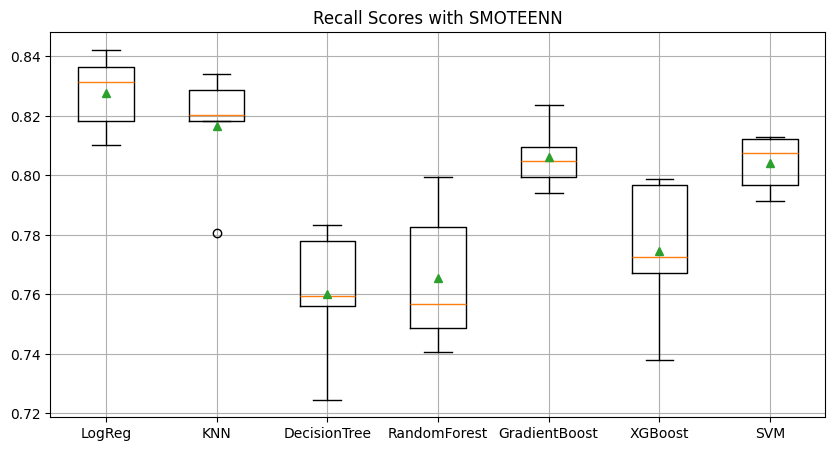

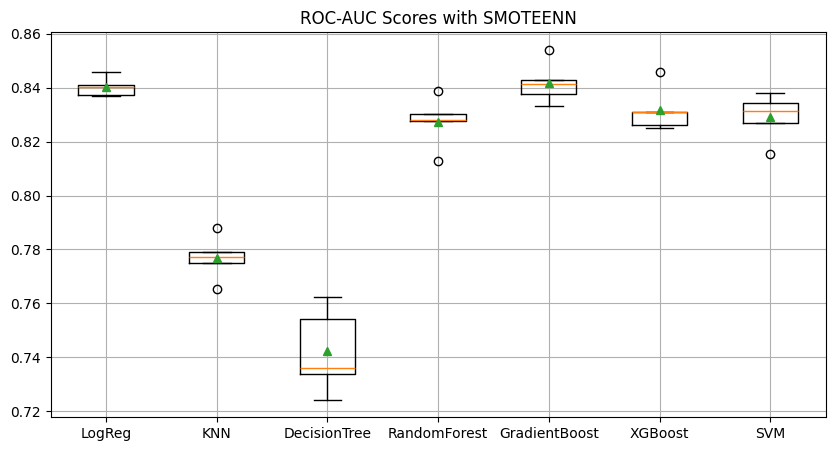

In [33]:
# Import Dataset
df = pd.read_csv("Telecom_Customers_Churn.csv")

# Apply preprocessing
df, num_features, multi_cat_features, bin_cat_features = preprocess_churn_data(df)
df = feature_engineering(df)

# ==== Features & Target ====
X = df.drop('Churn', axis=1)
y = df['Churn']

# ==== Preprocessor ====
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), multi_cat_features)
])

# Get models list
models, names = get_classifiers()

# === Evaluate All Models ===
recalls, rocs = [], []

for model, name in zip(models, names):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smoteenn', SMOTEENN(random_state=42)),
        ('classifier', model)
    ])

    r, roc = evaluate_classifier_with_sampling(X, y, pipeline)
    recalls.append(r)
    rocs.append(roc)

    print(f">{name} | Recall: {np.mean(r):.3f} | ROC-AUC: {np.mean(roc):.3f}")

# === Plot Results ===
# Recall
plt.figure(figsize=(10, 5))
plt.boxplot(recalls, labels=names, showmeans=True)
plt.title('Recall Scores with SMOTEENN')
plt.grid(True)
plt.show()

# ROC-AUC
plt.figure(figsize=(10, 5))
plt.boxplot(rocs, labels=names, showmeans=True)
plt.title('ROC-AUC Scores with SMOTEENN')
plt.grid(True)
plt.show()

Dalam proses eksperimen modeling, saya menguji beberapa algoritma klasifikasi yaitu `Logistic Regression`, `KNN`, `Decision Tree`, `Random Forest`, `Gradient Boosting`, `XGBoost`, dan `Support Vector Machine (SVM)`. Berdasarkan hasil evaluasi menggunakan metrik recall dan ROC-AUC, model `Logistic Regression` menunjukkan performa terbaik dengan nilai `recall` sebesar **0.827** dan `ROC-AUC` sebesar **0.840**. Distribusi nilai `recall` dari cross-validation berkisar antara **0.81 hingga 0.84**, sementara nilai `ROC-AUC` berkisar antara **0.83 hingga 0.85**, menunjukkan konsistensi performa yang baik.

Sebaliknya, model `Decision Tree` memberikan performa terburuk di antara model-model yang diuji. Hasil ini mengindikasikan bahwa data pada kasus ini relatif dapat dipisahkan secara linear, sehingga model linear seperti `Logistic Regression` lebih efektif dibandingkan dengan model berbasis pohon keputusan (tree-based models) yang cenderung overfitting terhadap noise atau pola yang kompleks dalam data.

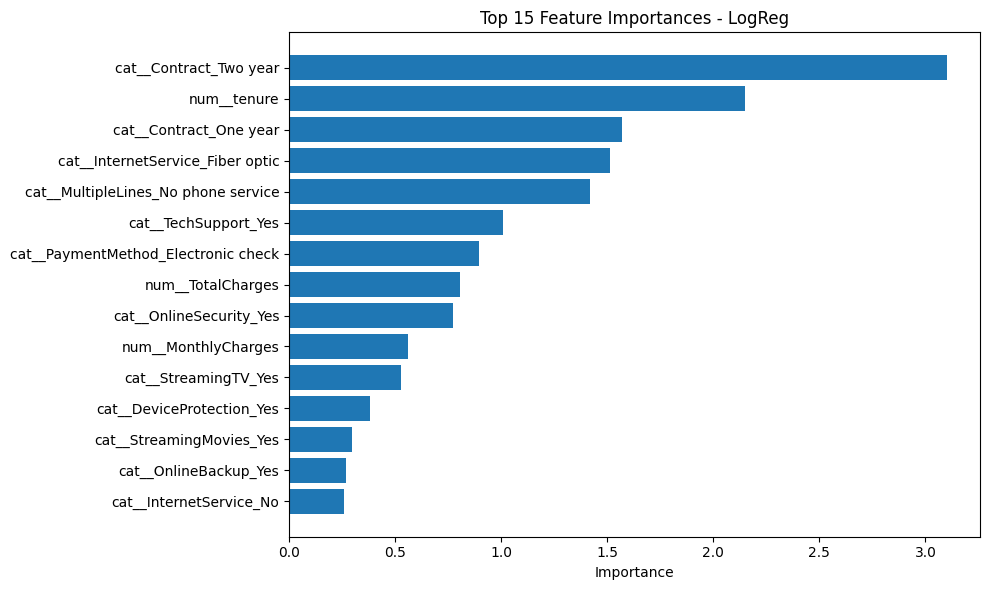

Model KNN tidak mendukung feature importance secara langsung.


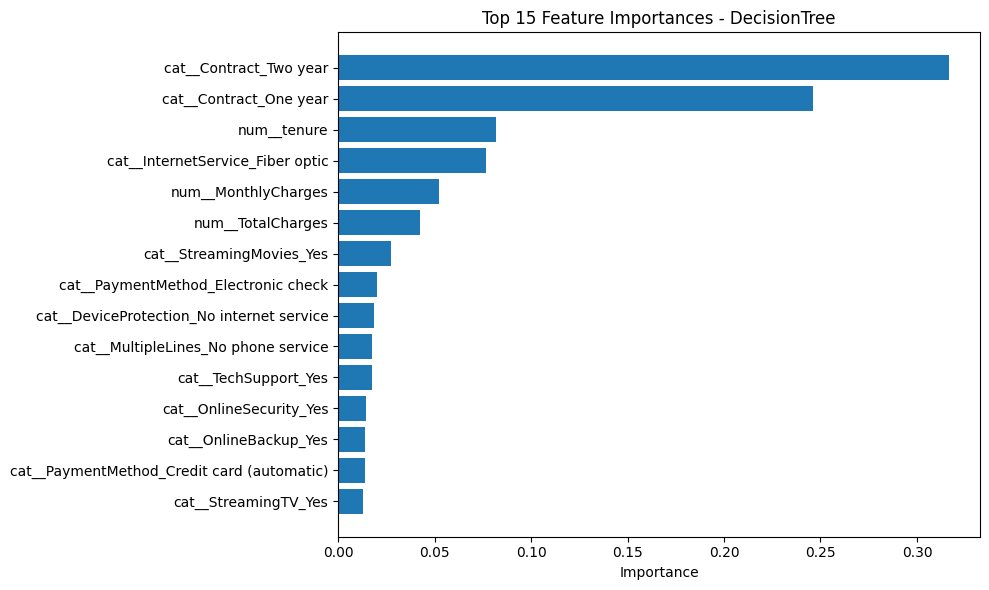

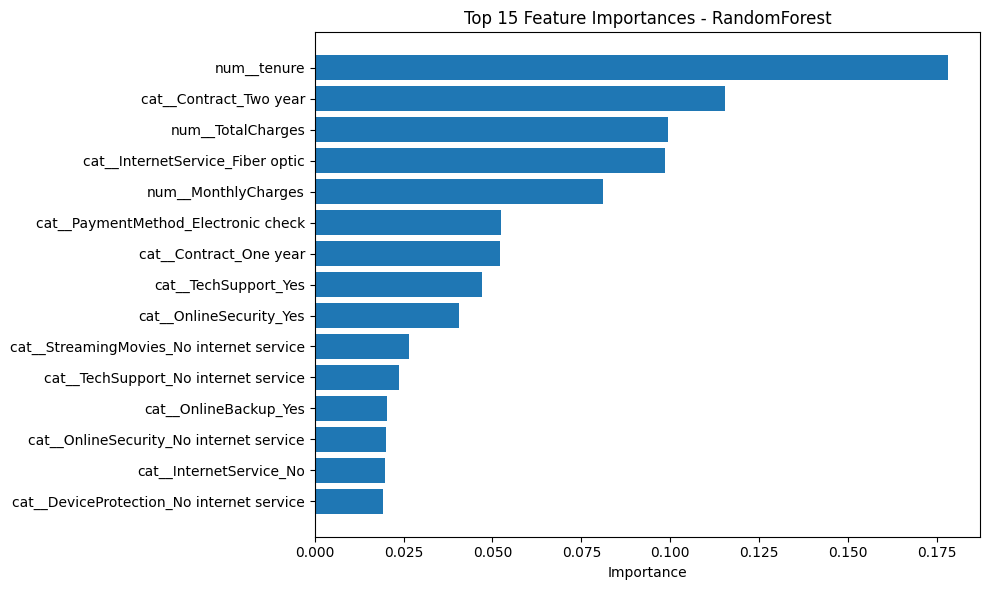

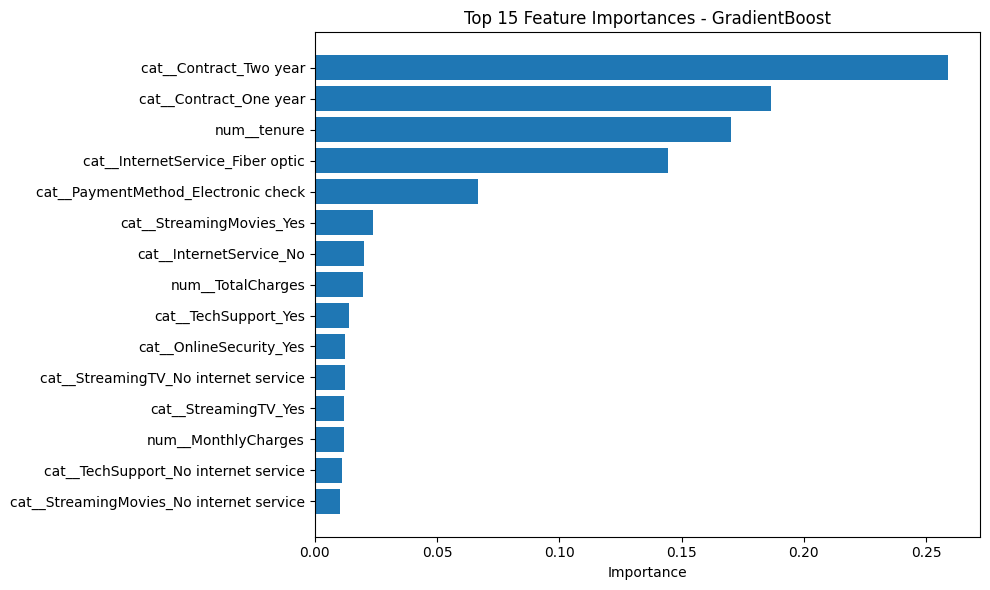

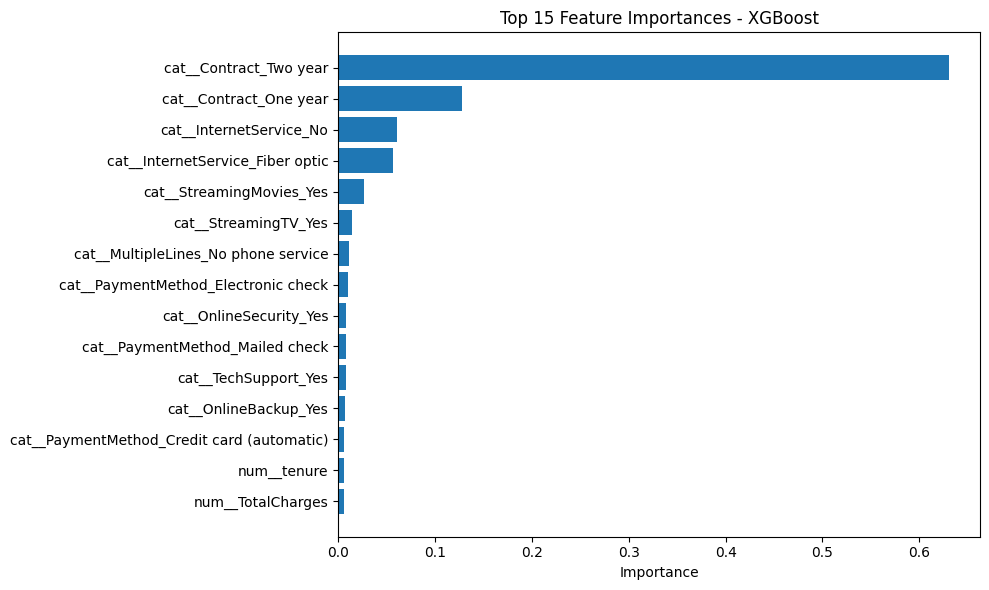

Model SVM tidak mendukung feature importance secara langsung.


In [34]:
for model, name in zip(models, names):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smoteenn', SMOTEENN(random_state=42)),
        ('classifier', model)
    ])

    plot_feature_importance(pipeline, name, X, y)

Berdasarkan hasil analisis feature importance dari beberapa model, fitur-fitur seperti `Contract`, `tenure`, `InternetService`, dan `MonthlyCharges` memiliki kontribusi paling besar dalam memprediksi kemungkinan pelanggan melakukan churn. Hal ini ditunjukkan oleh tingginya nilai feature importance pada kolom-kolom tersebut, yang menunjukkan bahwa informasi dari fitur-fitur ini sangat **relevan dalam membedakan pelanggan yang churn dan yang tidak**.

## Hyperparameter Tuning

In [35]:
# Import Dataset
df = pd.read_csv("Telecom_Customers_Churn.csv")

# Apply preprocessing
df, num_features, multi_cat_features, bin_cat_features = preprocess_churn_data(df)
df = feature_engineering(df)

# ==== Features & Target ====
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data untuk final evaluation setelah tuning
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Preprocessing Pipeline ===
base_steps = [
    ('preprocessor', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42))
]

# === Hanya Tuning XGBoost ===
xgb_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8],
}

xgb_pipeline = ImbPipeline(base_steps + [
    ('classifier', XGBClassifier(
        scale_pos_weight=(y == 0).sum() / (y == 1).sum(),  # untuk handling class imbalance
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        tree_method='gpu_hist',
        gpu_id=0,
    ))
])

xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_params,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Train
xgb_grid.fit(X_train, y_train)

# Hasil tuning
print("Best XGBoost Params:", xgb_grid.best_params_)

# === EVALUASI MODEL TERBAIK ===
best_model = xgb_grid.best_estimator_

# Prediksi
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluasi
print("\n--- XGBoost Evaluation ---")
print(classification_report(y_test, y_pred))
print("ROC-AUC :", roc_auc_score(y_test, y_proba))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best XGBoost Params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

--- XGBoost Evaluation ---
              precision    recall  f1-score   support

           0       0.94      0.60      0.73      1033
           1       0.44      0.89      0.59       374

    accuracy                           0.67      1407
   macro avg       0.69      0.74      0.66      1407
weighted avg       0.81      0.67      0.69      1407

ROC-AUC : 0.8377629147232245


Setelah dilakukan proses hyperparameter tuning terhadap beberapa algoritma klasifikasi, diperoleh bahwa model `XGBoost` memberikan performa terbaik dalam memprediksi churn pelanggan. Hal ini ditunjukkan dari nilai `recall` tertinggi sebesar **0.89** dan `ROC-AUC` sebesar **0.836**, yang berarti model ini paling efektif dalam memprediksi pelanggan yang berpotensi churn, sekaligus menjaga keseimbangan klasifikasi secara keseluruhan.

Meskipun beberapa model seperti `Random Forest` dan `Gradient Boosting` juga menunjukkan performa yang kompetitif, `XGBoost` unggul terutama dalam `recall` yang menjadi prioritas utama dalam kasus **imbalance** seperti ini. Oleh karena itu, model `XGBoost` dipilih sebagai model akhir untuk digunakan dalam prediksi churn pelanggan.

# Evaluation

== Classification Report (XGBoost) ==
              precision    recall  f1-score   support

           0       0.94      0.60      0.73      1033
           1       0.44      0.89      0.59       374

    accuracy                           0.67      1407
   macro avg       0.69      0.74      0.66      1407
weighted avg       0.81      0.67      0.69      1407

== ROC-AUC (XGBoost) ==
ROC-AUC Score: 0.8377629147232245


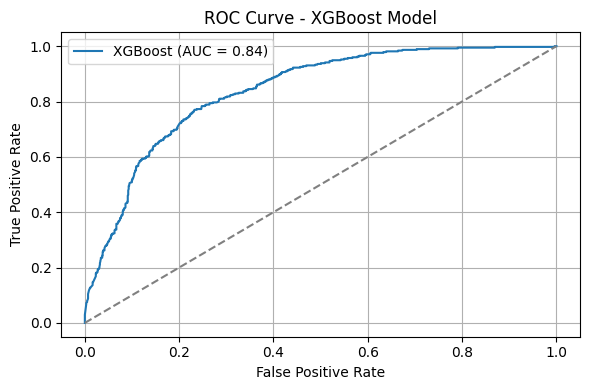

In [36]:
# Evaluasi akhir
final_model = best_model
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("== Classification Report (XGBoost) ==")
print(classification_report(y_test, y_pred))

print("== ROC-AUC (XGBoost) ==")
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost Model")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Dari hasil plotting **ROC Curve** untuk model `XGBoost`, diperoleh nilai **AUC (Area Under Curve)** sebesar **0.836**, yang mengindikasikan bahwa model memiliki kemampuan klasifikasi yang baik dalam membedakan pelanggan churn dan non-churn.

Pada kurva ROC, **garis biru** menunjukkan performa model `XGBoost`, dengan **True Positive Rate (TPR)** berada di kisaran **0.7–0.9** dan **False Positive Rate (FPR)** yang relatif rendah (sekitar **0.2–0.4**), dengan ambang batas klasifikasi yang digunakan sebesar **0.5** untuk menghasilkan prediksi kelas.

Sebagai perbandingan:
- **Garis putus-putus diagonal** (dari kiri bawah ke kanan atas) mewakili model yang melakukan prediksi secara **acak** (AUC = 0.5) — artinya model tersebut tidak memiliki kemampuan klasifikasi yang berguna.
- Model yang ROC curve-nya berada **di bawah garis diagonal** merupakan model yang justru memprediksi **secara terbalik**, dan dianggap sangat buruk.

Dengan demikian, **ROC curve XGBoost yang berada jauh di atas garis acak** menunjukkan bahwa model ini **bernilai prediktif tinggi** dan dapat digunakan untuk membantu mengidentifikasi pelanggan yang berisiko churn secara efektif.

# Save Model

In [38]:
# Simpan pipeline model yang sudah dilatih dan di-tuning
joblib.dump(best_model, 'xgboost_pipeline.pkl')

['xgboost_pipeline.pkl']

# Summary

Dari berbagai model yang diuji, `XGBoost` dipilih sebagai model terbaik karena menunjukkan performa paling optimal dengan `recall` sebesar **89%** dan `ROC-AUC` sebesar **0.836**, menjadikan model ini sangat efektif dalam mengidentifikasi pelanggan yang berisiko tinggi untuk churn.

Hasil Evaluasi XGBoost:

- **Recall** (kelas churn): 89%
- **Precision** (kelas churn): 44%
- **F1-Score** (kelas churn): 59%
- **Akurasi** keseluruhan: 67%
- **ROC-AUC**: 0.836

Meskipun `precision` untuk kelas churn relatif rendah, tingginya `recall` menunjukkan bahwa model ini sangat baik dalam memprediksi sebanyak mungkin pelanggan yang berisiko churn, yang sangat penting untuk strategi retensi.

Melalui eksplorasi data dan analisis korelasi, beberapa faktor penting yang memengaruhi churn diidentifikasi, antara lain:
- **Tenure rendah** (pelanggan baru) lebih rentan churn.
- **Monthly Charges tinggi** berasosiasi dengan peningkatan risiko churn.
- **Jenis kontrak** berperan signifikan: pelanggan dengan kontrak bulanan (**month-to-month**) lebih cenderung churn dibanding yang berkontrak tahunan.
- Pelanggan yang tidak menggunakan layanan tambahan seperti `Tech Support`, `Online Security`, dan `Device Protection` juga menunjukkan kecenderungan churn lebih tinggi.

Temuan ini dapat dimanfaatkan untuk menyusun rekomendasi strategis yang bisa dijalankan oleh tim bisnis, seperti:
- **Segmentasi pelanggan berisiko tinggi** berdasarkan skor churn untuk intervensi proaktif.
- **Penawaran khusus** (seperti diskon atau loyalty program) untuk pelanggan dengan kontrak jangka pendek dan tagihan tinggi.
- **Kampanye retensi personal dan prediktif** berbasis model machine learning.

Secara keseluruhan, proyek ini dapat digunakan untuk pengambilan keputusan retensi pelanggan secara lebih terarah dan efisien. Model churn prediction ini bisa diintegrasikan ke dalam sistem CRM sebagai alat bantu untuk strategi pencegahan churn yang berkelanjutan.